# Boilerplate

Package installation, loading, and dataloaders. There's also a simple model defined. You can change it your favourite architecture if you want.

In [75]:
# !pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64
pgd_k = 50 # Number of steps for PGD


np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN. You can change this if you want. If you change it, mention the architectural details in your report.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())

model = model.to(device)
model.train()

Sequential(
  (0): Normalize()
  (1): Net(
    (fc): Linear(in_features=784, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=10, bias=True)
  )
)

In [76]:
def imshow(img):
    plt.imshow(img.reshape(28,28), cmap="gray")

# Implement the Attacks

Functions are given a simple useful signature that you can start with. Feel free to extend the signature as you see fit.

You may find it useful to create a 'batched' version of PGD that you can use to create the adversarial attack.

In [77]:
# The last argument 'targeted' can be used to toggle between a targeted and untargeted attack.
def fgsm(model, x, true_y, eps):
    #TODO: implement this as an intermediate step of PGD
    # Notes: put the model in eval() mode for this function
    # x: input image, y: ground truth label, eps: epsilon
    x = x.detach().to(device)
    x.requires_grad = True
    model.zero_grad()
    loss_fn = nn.CrossEntropyLoss()
    y = model(x)
    loss = loss_fn(y, true_y)
    loss.backward()
    adv_x = x + eps * x.grad.data.sign()
    return torch.clamp(adv_x, 0, 1)


def pgd_untargeted(model, x, y, k, eps, eps_step):
    #TODO: implement this
    # Notes: put the model in eval() mode for this function
    # x: input image
    # y: ground truth label for x
    # k: steps of FGSM
    # eps: projection region for PGD (note the need for normalization before projection, as eps values are for inputs in [0,1])
    # eps_step: step for one iteration of FGSM
    original_x = x
    for i in range(k):
      x = fgsm(model, x, y, eps_step)
      x = torch.maximum(torch.minimum(original_x + eps, x), original_x - eps)
      x = torch.clamp(x, 0, 1)
    return x

# Implement Adversarial Training

In [78]:
def train_model(model, num_epochs, enable_defense=True, attack='pgd', eps=0.1):
    # TODO: implement this function that trains a given model on the MNIST dataset.
    # this is a general-purpose function for both standard training and adversarial training.
    # (toggle enable_defense parameter to switch between training schemes)
    lr = 1e-3
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    size = len(train_loader.dataset)
    model.train()

    for epoch in range(num_epochs):
      for batch, (x, true_y) in enumerate(train_loader):
        x = x.to(device)
        true_y = true_y.to(device)
        y = model(x)
        loss = loss_fn(y, true_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (enable_defense):
          # If enabled, generate an adversarial example for every image and train
          adv_x = pgd_untargeted(model, x, true_y, pgd_k, eps, eps/pgd_k * 1.5)
          y = model(adv_x)
          loss = loss_fn(y, true_y)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      print(f"loss: {loss.item()} epoch: {epoch}/{num_epochs}")


In [79]:
def test_model_on_attacks(model, attack='pgd', eps=0.1):
    # TODO: implement this function to test the robust accuracy of the given model
    # use pgd_untargeted() within this function
    # Returns robust accuracy, adv accuracy

    model.eval()
    robust_total = 0
    robust_correct = 0
    adv_correct = 0
    adv_total = 0
    for x, true_y in test_loader:
      x = x.to(device)
      true_y = true_y.to(device)

      out = model(x)
      _, y = torch.max(out.data, 1)
      robust_correct += (y == true_y).sum().item()
      robust_total += true_y.size(0)
      # Robust accuracy

      adv_x = pgd_untargeted(model, x, true_y, pgd_k, eps, eps/pgd_k * 1.5)
      _, y = torch.max(model(adv_x).data,1)
      robust_correct += (y == true_y).sum().item()
      robust_total += true_y.size(0)
      adv_correct += (y == true_y).sum().item()
      adv_total += true_y.size(0)

    print(f"Robust accuracy for eps={eps}: {robust_correct/robust_total}")
    print(f"Adversarial accuracy for eps={eps} (evaluated on only adversarial examples): {adv_correct/adv_total}")
    return robust_correct/robust_total,adv_correct/adv_total


def test_model(model):
    model.eval()
    total = 0
    standard_correct = 0
    for x, true_y in test_loader:
      x = x.to(device)
      true_y = true_y.to(device)

      # Standard accuracy
      out = model(x)
      _, y = torch.max(out.data, 1)
      standard_correct += (y == true_y).sum().item()
      total += true_y.size(0)

    print(f"Standard accuracy: {standard_correct/total}")
    return standard_correct/total

# Study Accuracy, Quality, etc.

Compare the various results and report your observations on the submission.

In [ ]:
## train the original model
model = nn.Sequential(Normalize(), Net())
model = model.to(device)
model.train()

train_model(model, 20, False)
torch.save(model.state_dict(), 'weights.pt')

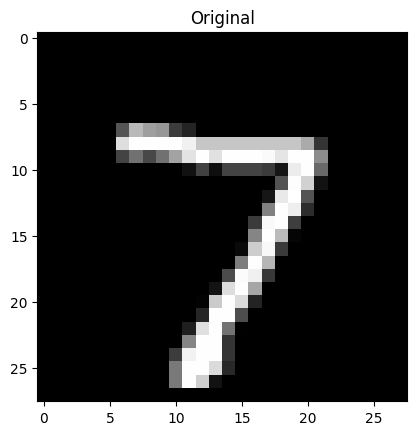

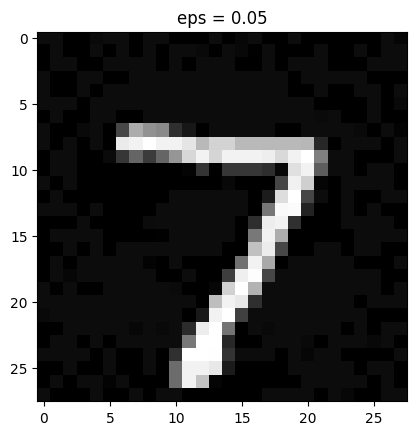

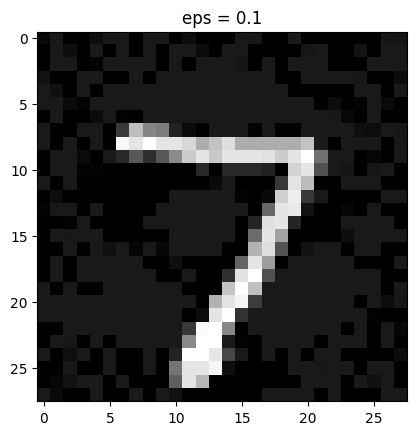

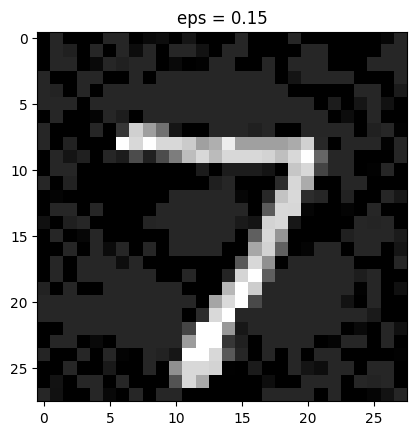

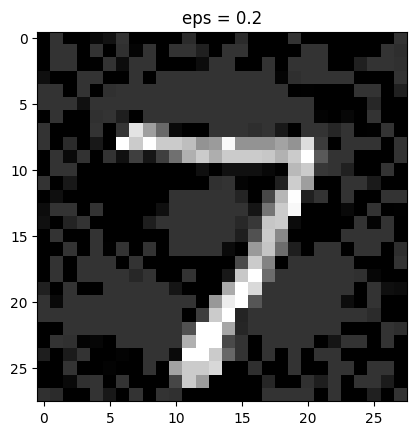

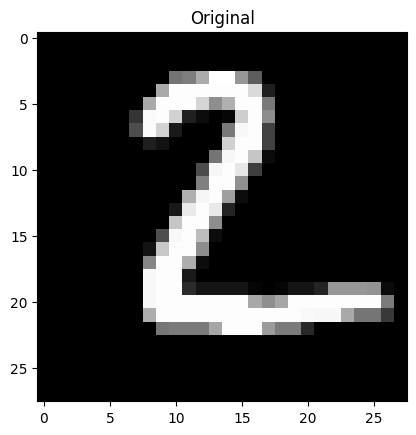

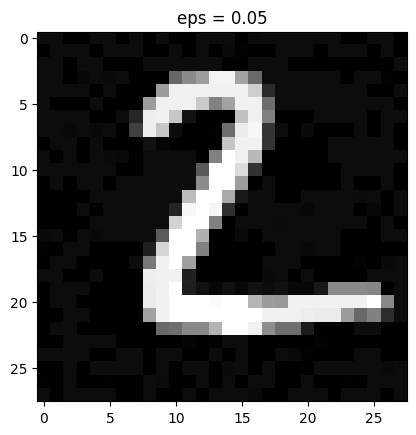

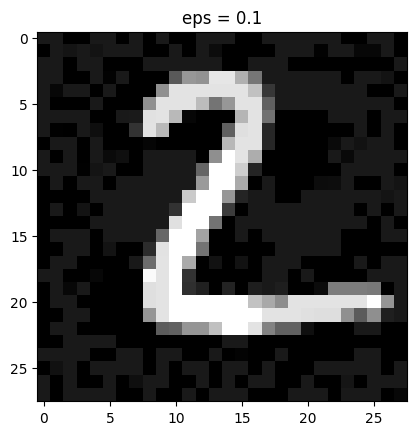

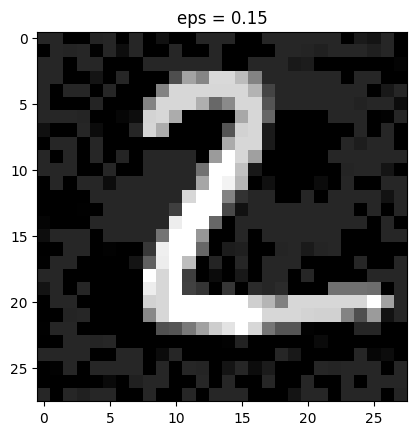

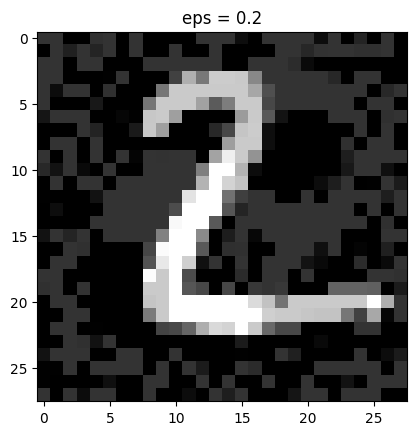

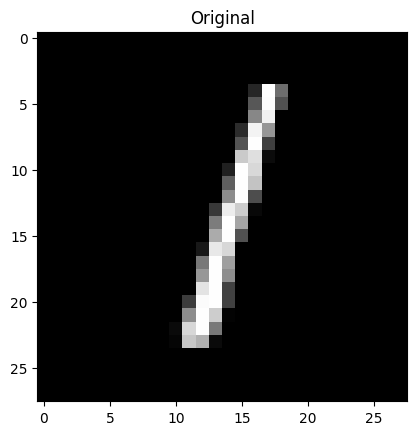

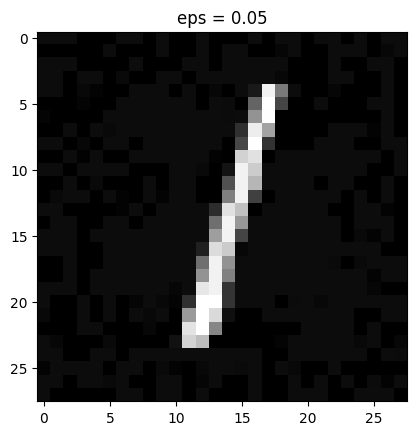

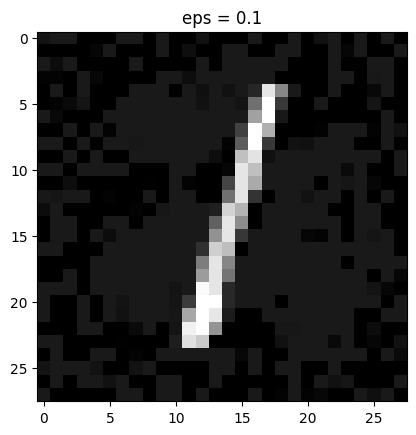

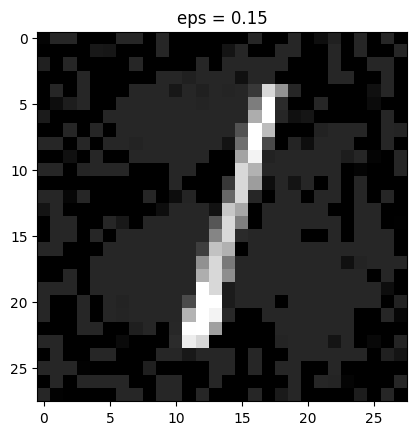

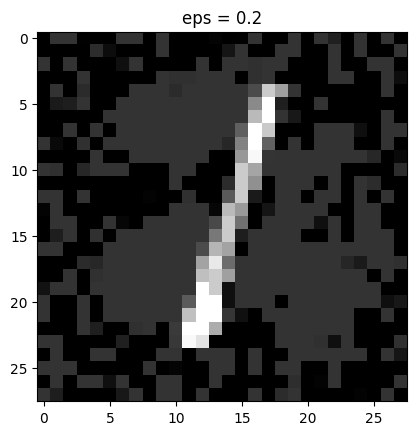

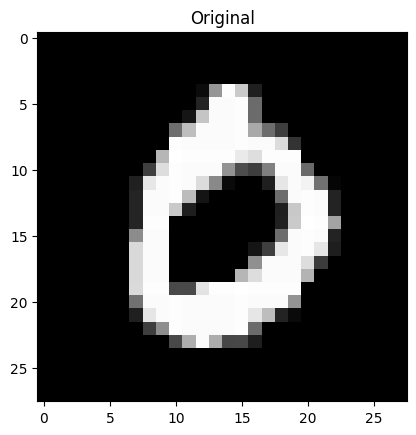

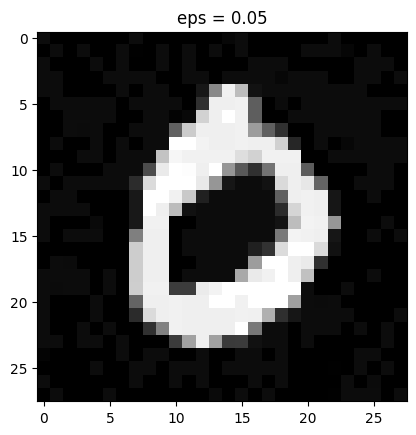

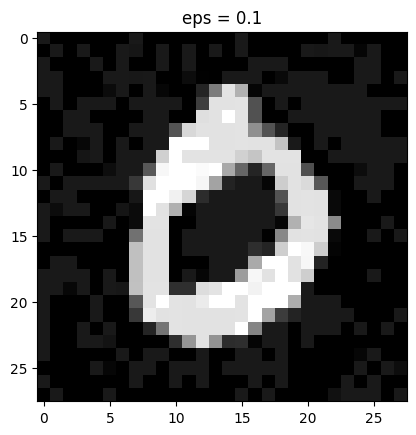

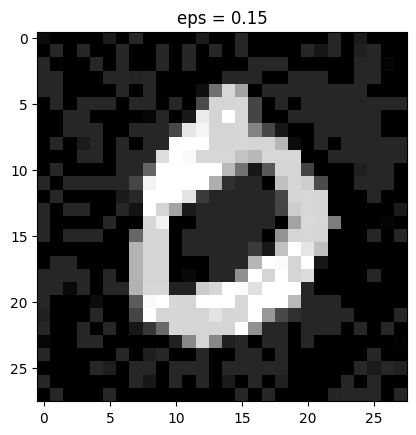

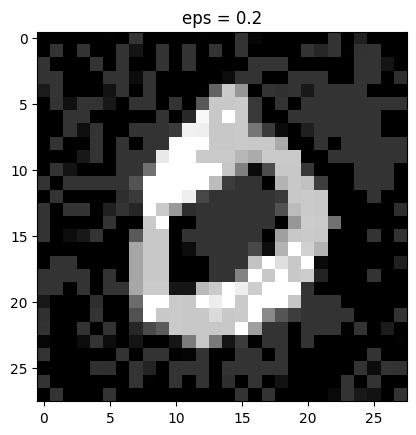

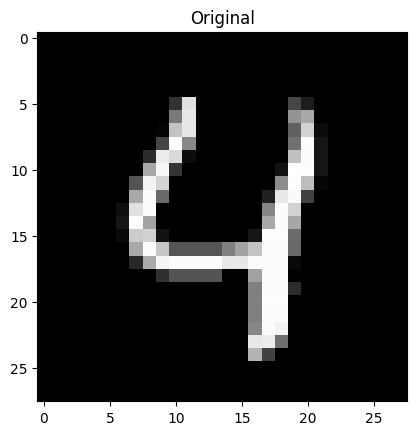

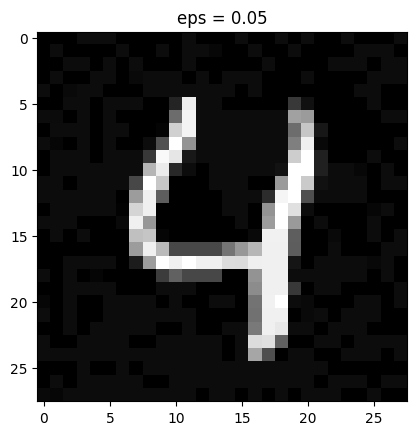

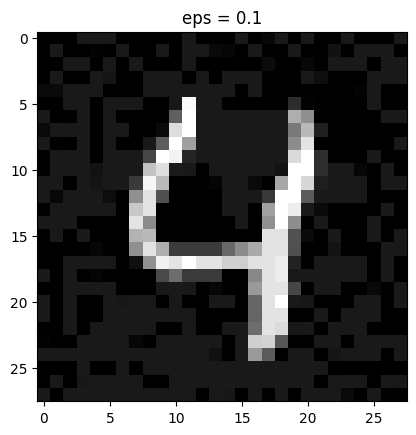

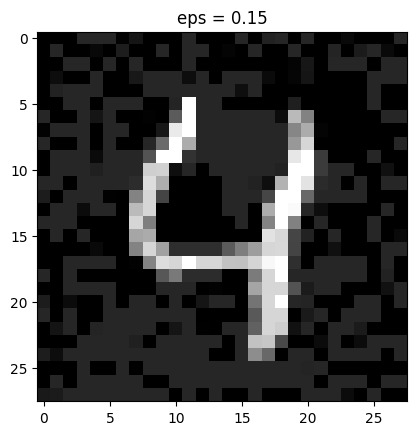

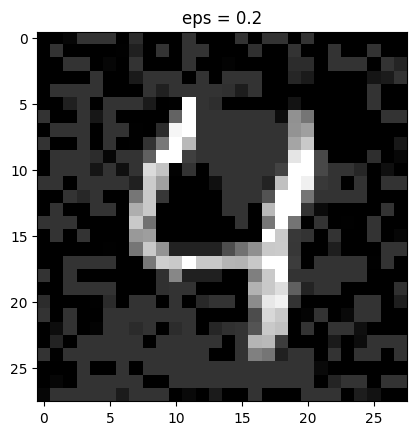

In [81]:
# Visualize attack
x, true_y = next(iter(test_loader))
x = x.to(device)
true_y = true_y.to(device)

for i in range(5):
  imshow(x[i].to("cpu"))
  plt.title("Original")
  plt.show()
  for eps in [0.05, 0.1, 0.15, 0.2]:
    adv_x = pgd_untargeted(model, x, true_y, pgd_k, eps, eps/pgd_k * 1.5)
    imshow(adv_x[i].to("cpu").detach())
    plt.title(f"eps = {eps}")
    plt.show()

<ipython-input-80-8d24b1347a2b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights.pt'))


Robust accuracy for eps=0.05: 0.8147
Adversarial accuracy for eps=0.05 (evaluated on only adversarial examples): 0.7045
Robust accuracy for eps=0.1: 0.5795
Adversarial accuracy for eps=0.1 (evaluated on only adversarial examples): 0.2341
Robust accuracy for eps=0.15: 0.47765
Adversarial accuracy for eps=0.15 (evaluated on only adversarial examples): 0.0304
Robust accuracy for eps=0.2: 0.46375
Adversarial accuracy for eps=0.2 (evaluated on only adversarial examples): 0.0026
Standard accuracy: 0.9249


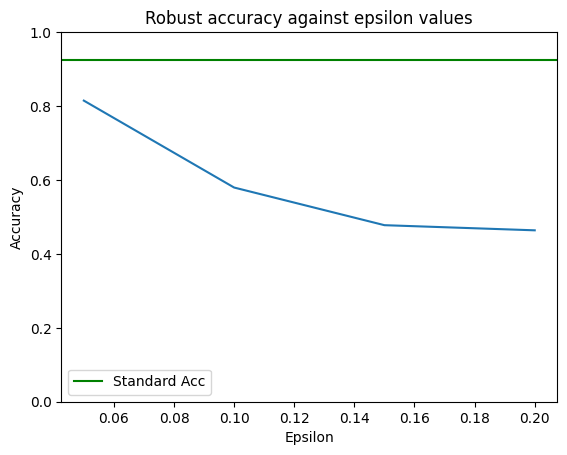

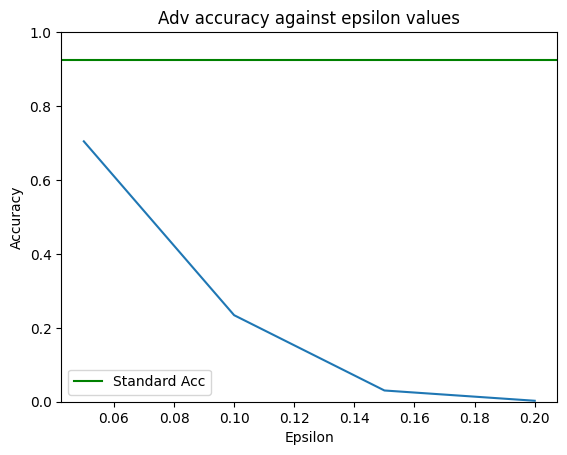

In [80]:
## Evaluate PGD attack robustness
model = nn.Sequential(Normalize(), Net())
model.load_state_dict(torch.load('weights.pt'))

model.to(device)

robust_acc = []
adv_acc = []
eps_vals = [0.05, 0.1, 0.15, 0.2]
for eps in eps_vals:
    r,a = test_model_on_attacks(model, attack='pgd', eps=eps)
    robust_acc.append(r)
    adv_acc.append(a)

standard_acc = test_model(model)
plt.plot(eps_vals, robust_acc)
l = plt.axhline(standard_acc, color='g', label='Standard Acc')
plt.title("Robust accuracy against epsilon values")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(handles=[l])
plt.ylim(0, 1)
plt.show()

plt.plot(eps_vals, adv_acc)
l = plt.axhline(standard_acc, color='g', label='Standard Acc')
plt.legend(handles=[l])
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Adv accuracy against epsilon values")
plt.ylim(0, 1)
plt.show()

In [ ]:
## PGD based adversarial training
model = nn.Sequential(Normalize(), Net())
eps = 0.1
train_model(model, 20, True, 'pgd', eps)
torch.save(model.state_dict(), f'weights_AT_{eps}.pt')

loss: 1.728670358657837 epoch: 0/20
loss: 1.3107093572616577 epoch: 1/20
loss: 1.1171157360076904 epoch: 2/20
loss: 1.184112787246704 epoch: 3/20
loss: 1.0860575437545776 epoch: 4/20
loss: 1.4197627305984497 epoch: 5/20
loss: 0.8917459845542908 epoch: 6/20
loss: 1.4140324592590332 epoch: 7/20
loss: 0.650679886341095 epoch: 8/20
loss: 0.8939230442047119 epoch: 9/20
loss: 1.1267985105514526 epoch: 10/20
loss: 0.3652940094470978 epoch: 11/20
loss: 1.136257529258728 epoch: 12/20
loss: 0.9704946279525757 epoch: 13/20
loss: 0.8838055729866028 epoch: 14/20
loss: 1.0375258922576904 epoch: 15/20
loss: 0.9859070181846619 epoch: 16/20
loss: 0.7146793007850647 epoch: 17/20
loss: 0.7957582473754883 epoch: 18/20
loss: 0.9289993047714233 epoch: 19/20


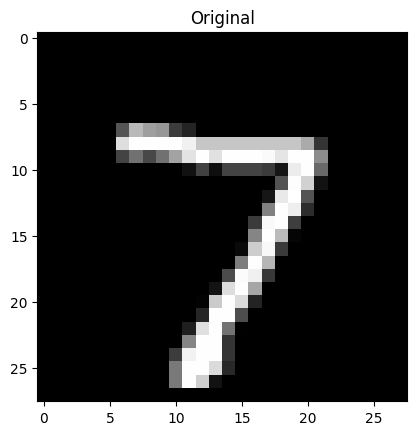

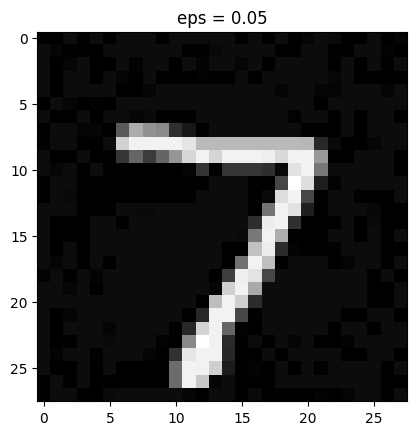

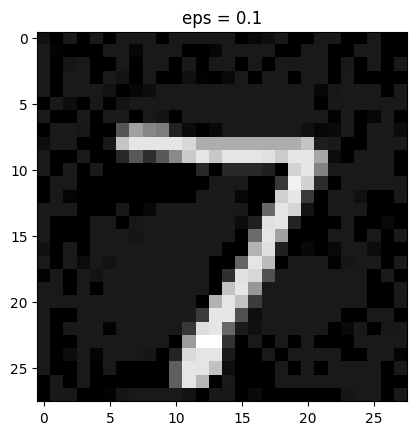

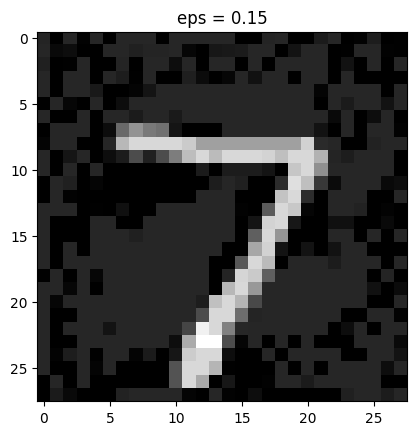

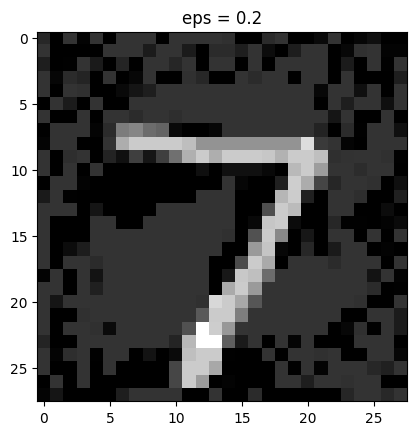

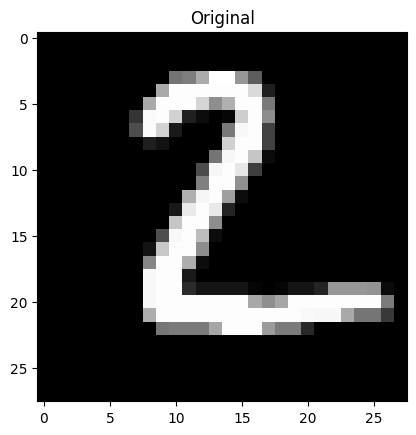

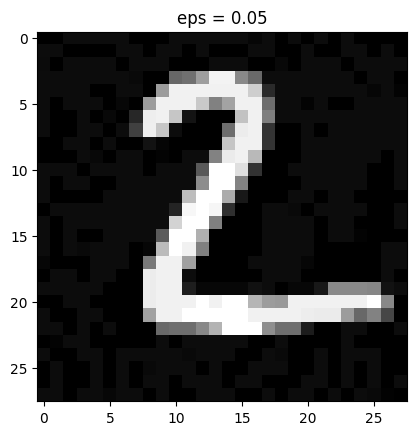

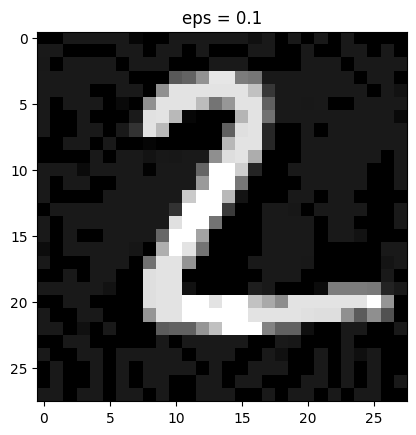

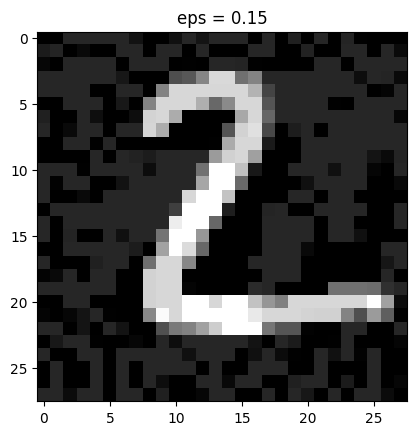

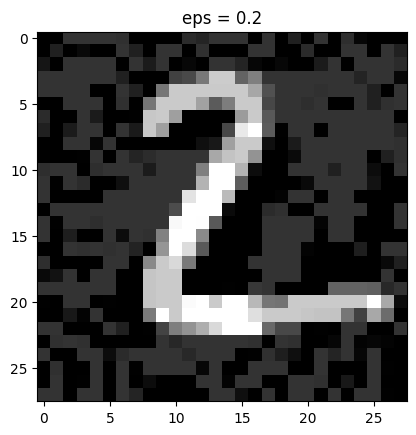

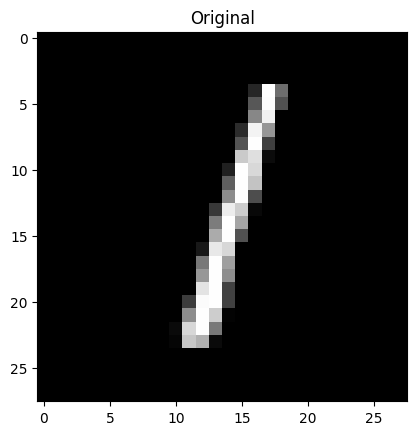

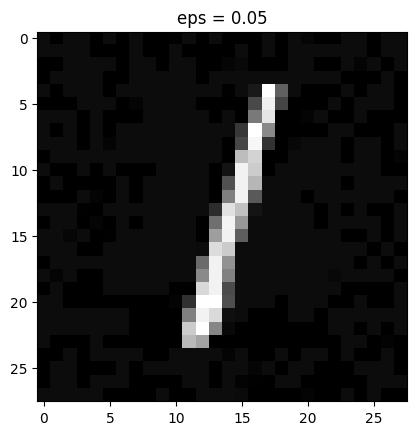

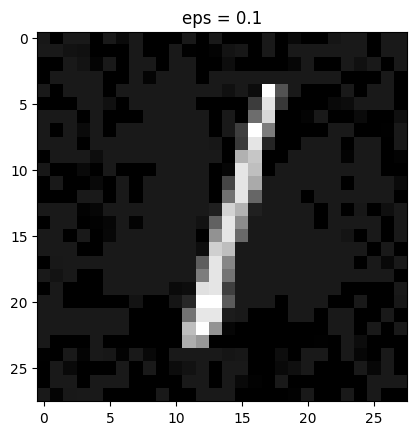

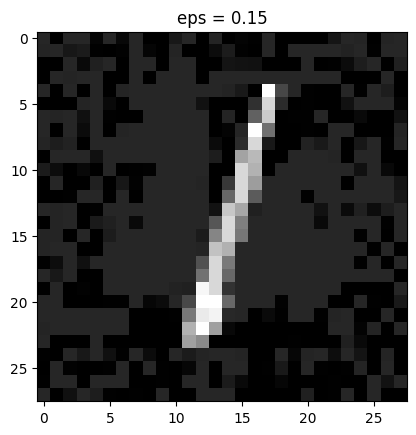

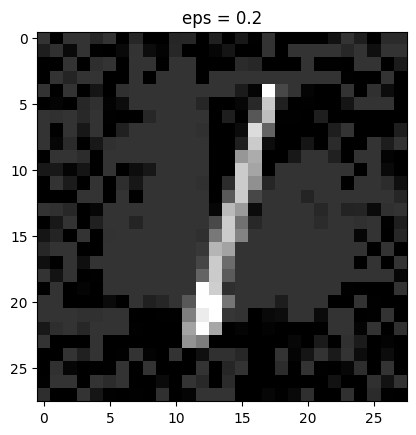

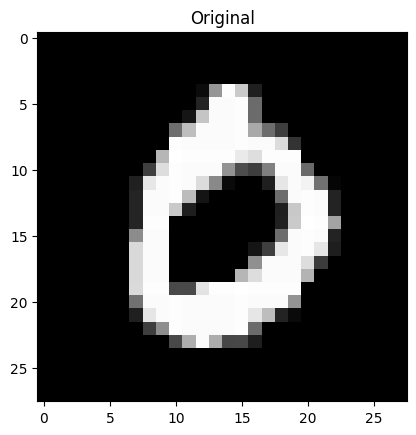

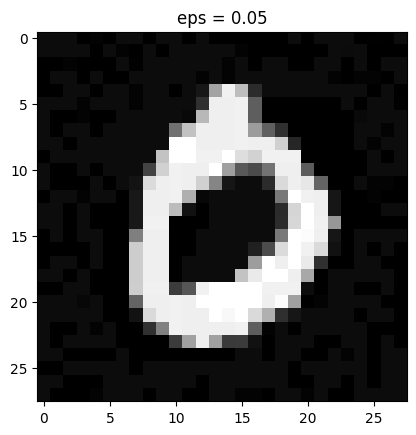

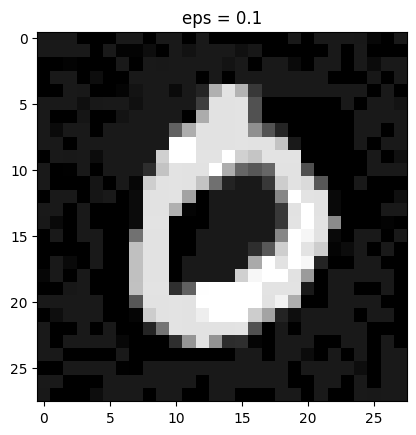

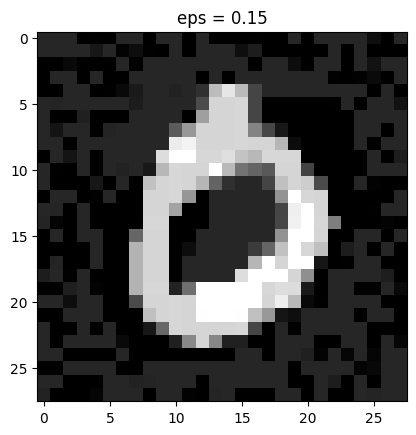

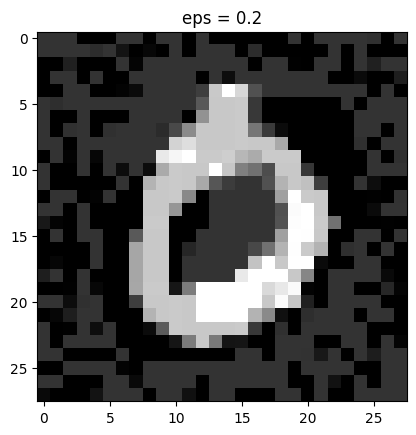

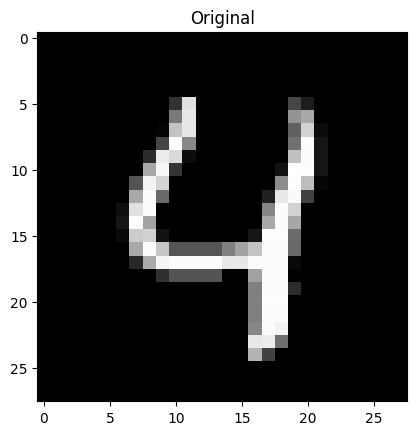

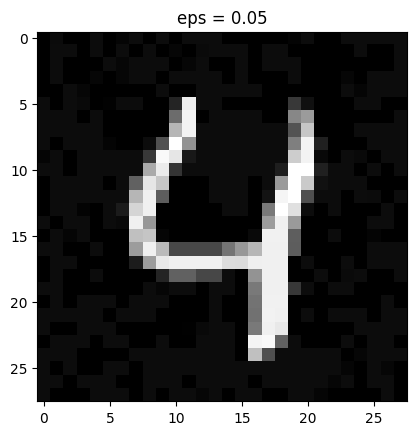

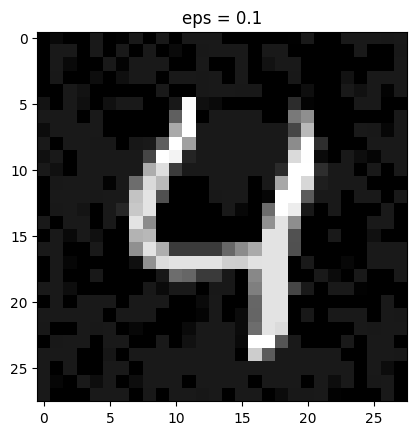

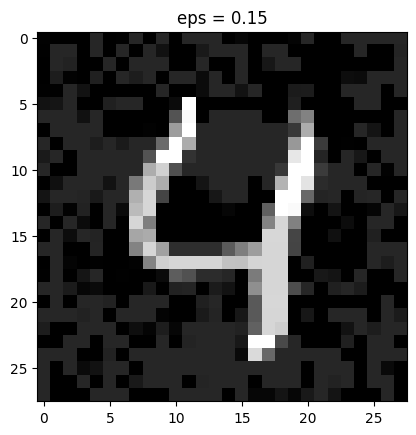

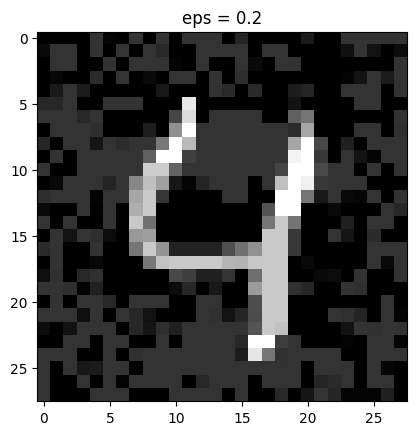

In [ ]:
# Visualize attack
x, true_y = next(iter(test_loader))
x = x.to(device)
true_y = true_y.to(device)

for i in range(5):
  imshow(x[i].to("cpu"))
  plt.title("Original")
  plt.show()
  for eps in [0.05, 0.1, 0.15, 0.2]:
    adv_x = pgd_untargeted(model, x, true_y, pgd_k, eps, eps/pgd_k * 1.5)
    imshow(adv_x[i].to("cpu").detach())
    plt.title(f"eps = {eps}")
    plt.show()

<ipython-input-49-274e8972962c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights_AT_0.1.pt'))


Robust accuracy for eps=0.05: 0.88915
Adversarial accuracy for eps=0.05 (evaluated on only adversarial examples): 0.8484
Robust accuracy for eps=0.1: 0.81515
Adversarial accuracy for eps=0.1 (evaluated on only adversarial examples): 0.7004
Robust accuracy for eps=0.15: 0.68915
Adversarial accuracy for eps=0.15 (evaluated on only adversarial examples): 0.4484
Robust accuracy for eps=0.2: 0.5457
Adversarial accuracy for eps=0.2 (evaluated on only adversarial examples): 0.1615
Standard accuracy: 0.9299


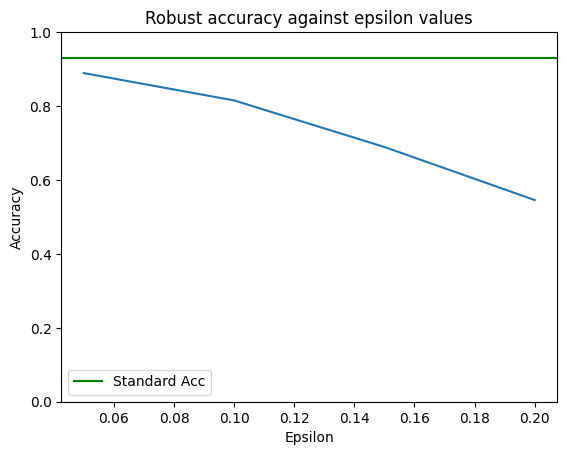

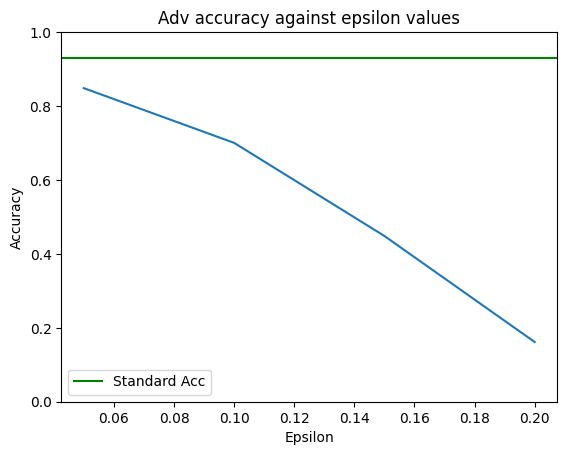

In [49]:
## Evaluate PGD attack robustness
model = nn.Sequential(Normalize(), Net())
model.load_state_dict(torch.load('weights_AT_0.1.pt'))

model.to(device)

robust_acc = []
adv_acc = []
eps_vals = [0.05, 0.1, 0.15, 0.2]
for eps in eps_vals:
    r,a = test_model_on_attacks(model, attack='pgd', eps=eps)
    robust_acc.append(r)
    adv_acc.append(a)

standard_acc = test_model(model)
plt.plot(eps_vals, robust_acc)
l = plt.axhline(standard_acc, color='g', label='Standard Acc')
plt.title("Robust accuracy against epsilon values")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(handles=[l])
plt.ylim(0, 1)
plt.show()
plt.plot(eps_vals, adv_acc)
l = plt.axhline(standard_acc, color='g', label='Standard Acc')
plt.legend(handles=[l])
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Adv accuracy against epsilon values")
plt.ylim(0, 1)
plt.show()

In [ ]:
#!pip install torchattacks

In [72]:

# Use TorchAttacks library's implementation of autoattack
import torchattacks
from tqdm import tqdm
def evaluate_AA(model, eps):

  model.eval()
  attack = torchattacks.AutoAttack(model, norm='Linf', eps=eps, version='standard', n_classes=10, seed=None, verbose=False)
  adv_correct = 0
  adv_total = 0
  num_batches = 20
  for x, true_y in test_loader:
    x = x.to(device)
    true_y = true_y.to(device)

    adv_images = attack(x, true_y)
    _, y = torch.max(model(adv_images).data,1)
    adv_correct += (y == true_y).sum().item()
    adv_total += true_y.size(0)
    num_batches -= 1
    if num_batches == 0:
      break

  print(f"Adversarial accuracy for eps={eps} against AA(evaluated on only adversarial examples): {adv_correct/adv_total}")
  return adv_correct/adv_total

In [73]:
def evaluate_FGSM(model, eps):
  model.eval()
  adv_correct = 0
  adv_total = 0
  for x, true_y in tqdm(test_loader):
    x = x.to(device)
    true_y = true_y.to(device)

    adv_images = fgsm(model, x, true_y, eps)
    _, y = torch.max(model(adv_images).data,1)
    adv_correct += (y == true_y).sum().item()
    adv_total += true_y.size(0)

  print(f"Adversarial accuracy for eps={eps} against FGSM (evaluated on only adversarial examples): {adv_correct/adv_total}")
  return adv_correct/adv_total

<ipython-input-74-6fb9ae96a58d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights_AT_0.1.pt'))


Adversarial accuracy for eps=0.05 against AA(evaluated on only adversarial examples): 0.80078125


100%|██████████| 157/157 [00:02<00:00, 52.90it/s]


Adversarial accuracy for eps=0.05 against FGSM (evaluated on only adversarial examples): 0.8502
Adversarial accuracy for eps=0.1 against AA(evaluated on only adversarial examples): 0.6234375


100%|██████████| 157/157 [00:02<00:00, 74.37it/s]


Adversarial accuracy for eps=0.1 against FGSM (evaluated on only adversarial examples): 0.7158
Adversarial accuracy for eps=0.15 against AA(evaluated on only adversarial examples): 0.3234375


100%|██████████| 157/157 [00:02<00:00, 66.15it/s]


Adversarial accuracy for eps=0.15 against FGSM (evaluated on only adversarial examples): 0.5065
Adversarial accuracy for eps=0.2 against AA(evaluated on only adversarial examples): 0.0609375


100%|██████████| 157/157 [00:02<00:00, 75.35it/s]


Adversarial accuracy for eps=0.2 against FGSM (evaluated on only adversarial examples): 0.2531


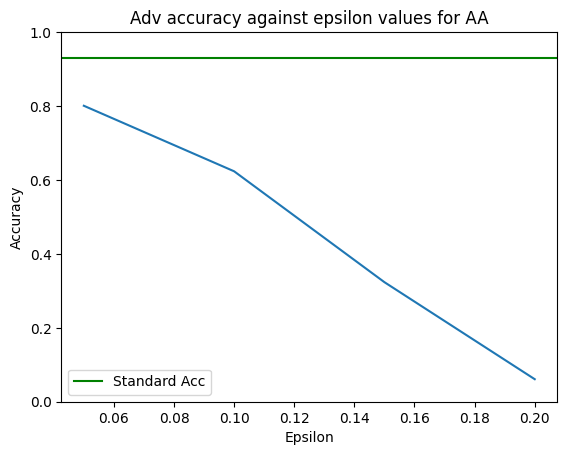

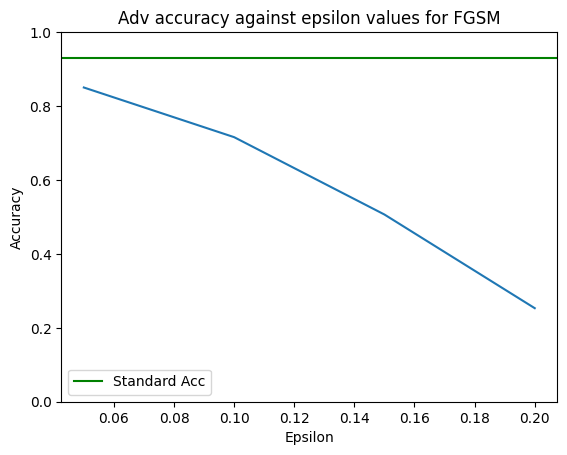

In [74]:
## Evaluate AA and FGSM attack robustness
model = nn.Sequential(Normalize(), Net())
model.load_state_dict(torch.load('weights_AT_0.1.pt'))

model.to(device)

AA_adv_acc = []
FGSM_adv_acc = []
eps_vals = [0.05, 0.1, 0.15, 0.2]
for eps in eps_vals:
    AA_adv_acc.append(evaluate_AA(model, eps))
    FGSM_adv_acc.append(evaluate_FGSM(model, eps))

plt.plot(eps_vals, AA_adv_acc)
l = plt.axhline(standard_acc, color='g', label='Standard Acc')
plt.title("Adv accuracy against epsilon values for AA")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(handles=[l])
plt.ylim(0, 1)
plt.show()
plt.plot(eps_vals, FGSM_adv_acc)
l = plt.axhline(standard_acc, color='g', label='Standard Acc')
plt.legend(handles=[l])
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Adv accuracy against epsilon values for FGSM")
plt.ylim(0, 1)
plt.show()